<a href="https://colab.research.google.com/github/rheopy/rheofit/blob/master/data/Rheology%20finds%20distinct%20glass%20and%20jamming%20transitions%20in%20emulsions/TC_analysis_fig2b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/rheopy/rheofit.git

  Cloning https://github.com/rheopy/rheofit.git to /tmp/pip-req-build-9nrmu_8v
  Running command git clone -q https://github.com/rheopy/rheofit.git /tmp/pip-req-build-9nrmu_8v
     |████████████████████████████████| 266kB 13.5MB/s 
     |████████████████████████████████| 51kB 5.5MB/s 
     |████████████████████████████████| 61kB 6.9MB/s 
     |████████████████████████████████| 256kB 19.6MB/s 
  Created wheel for rheofit: filename=rheofit-0.1.0-cp36-none-any.whl size=9874 sha256=b8743003f969c099d8b23137214efd7c6e196d9e7b8766ffabc38bc887ee3e8f
  Stored in directory: /tmp/pip-ephem-wheel-cache-xkpu_3f3/wheels/a4/58/61/22fb357c158d287fa7e6b6a2b1cc7379d68d1d40fdbb8daf64
  Created wheel for lmfit: filename=lmfit-1.0.1-cp36-none-any.whl size=81991 sha256=5720fc93c05956576319c8e649df3dba60df8ea5e6bbe6baec7fbf51abae976a
  Stored in directory: /root/.cache/pip/wheels/ef/22/8d/6cd9c0af36f501cfb248673b05dad5d2c27504951d55519acb
  Created wheel for asteval: filename=asteval-0.9.21-cp36-none-any.whl

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import lmfit
from IPython.display import Math

import rheofit
import pybroom as pb
import corner

import seaborn as sns
import io
from scipy.interpolate import UnivariateSpline
import numpy as np


In [3]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

In [4]:
!git clone https://github.com/rheopy/rheofit.git

Cloning into 'rheofit'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 508 (delta 14), reused 0 (delta 0), pack-reused 471
Receiving objects: 100% (508/508), 3.22 MiB | 5.94 MiB/s, done.
Resolving deltas: 100% (294/294), done.


In [5]:
#check units - assuming SI

filename_fig2a='2011.11806_fig2b_Shear rate_Stress_s-1_Pa.csv'
xlabel=filename_fig2a.split('_')[2]
ylabel=filename_fig2a.split('_')[3]

sample_list=list(pd.read_csv(f'/content/rheofit/data/Rheology finds distinct glass and jamming transitions in emulsions/{filename_fig2a}',nrows=1).columns)[::2]
data_table=pd.read_csv(f'/content/rheofit/data/Rheology finds distinct glass and jamming transitions in emulsions/{filename_fig2a}',skiprows=1)
data_table

data_dict={}
for sample_index, sample_label in enumerate(sample_list):
  single_table=data_table.iloc[:,[sample_index*2,sample_index*2+1]]
  single_table.columns=[xlabel,ylabel]
  single_table.sort_values(by=xlabel,inplace=True)

  data_dict[sample_label]=single_table

# data interpolation example
# data=pd.read_excel('FC_0775.xlsx')
# int_y=UnivariateSpline(data['Shear rate'],data['Stress'],k=1)
# int_x=np.logspace(np.log10(min(data['Shear rate'])),np.log10(max(data['Shear rate'])),100)
# int_data=pd.DataFrame()
# int_data['Shear rate']=int_x
# int_data['Stress']=int_y(int_x)
# data_dict['FC_0775.xlsx']=data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [25]:
TC=rheofit.models.TC_model
TC.set_param_hint('TC_gammadot_crit', vary=False, value=5)

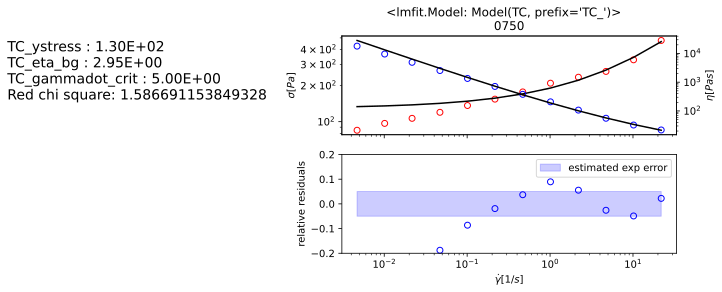

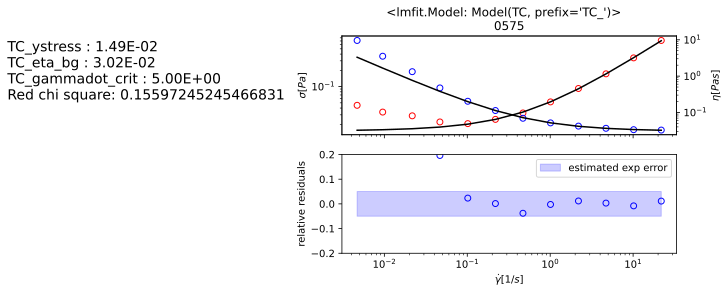

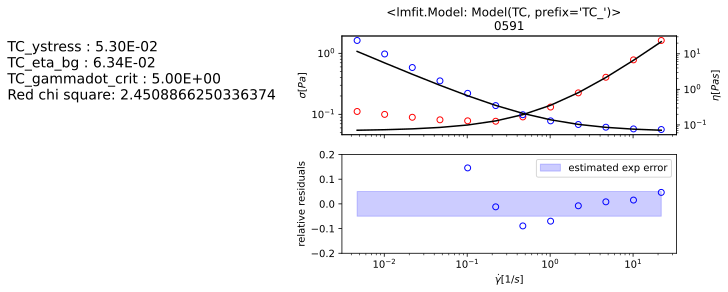

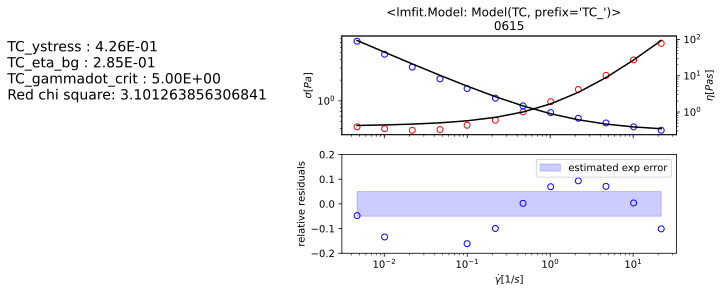

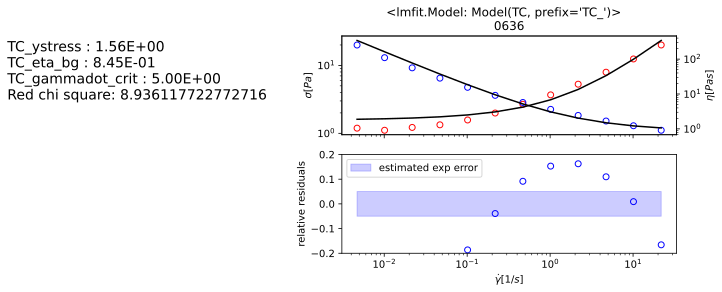

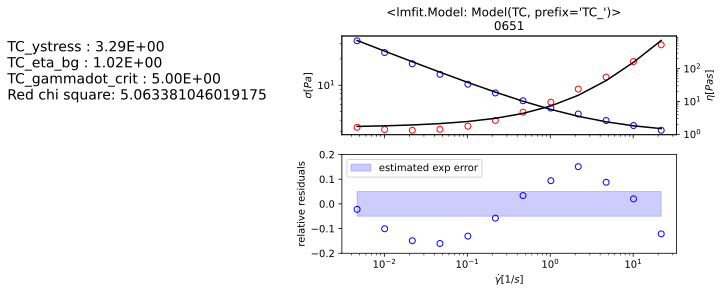

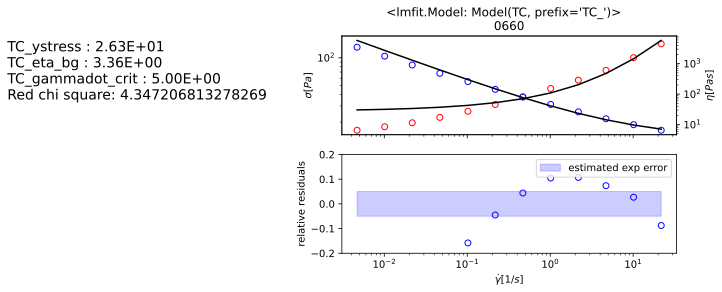

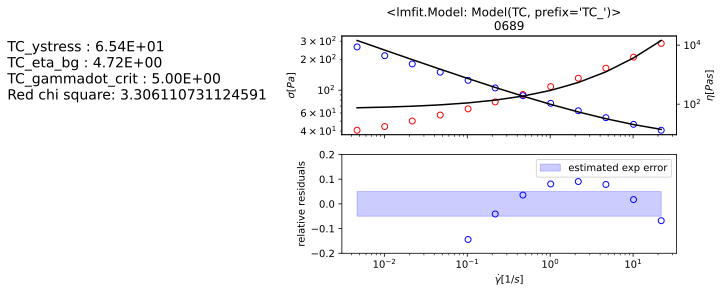

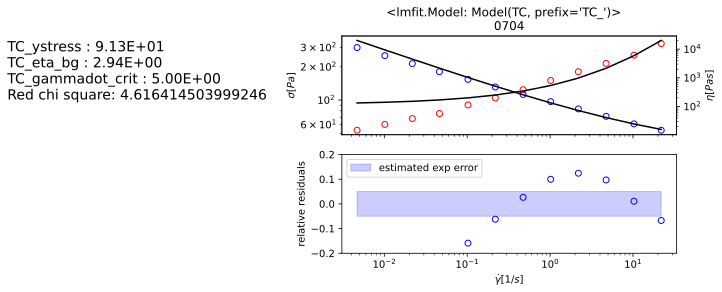

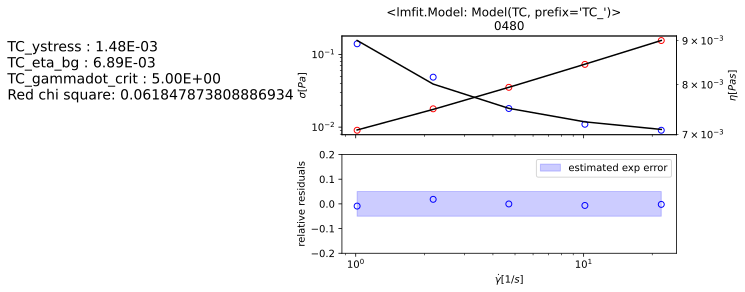

In [34]:
fit_res_dict={}

model = TC

min_shear_rate=0.1

max_shear_rate=10000

for filename, data in data_dict.items():
    mask=(data['Shear rate']>=min_shear_rate) & (data['Shear rate']<=max_shear_rate)    
    fit_res=model.fit(data['Stress'],x=data['Shear rate'],
                                     weights=1/(0.05*data[mask]['Stress']),
                                     nan_policy='omit')
    fit_res_dict[filename]=fit_res
    
for filename,fit_res in fit_res_dict.items():
    rheofit.visualization.plot_fit_res(fit_res, show_par_values=True);
    plt.title(filename)

In [35]:
table_result=pb.tidy(fit_res_dict)
table_result['vol_frac']=table_result['key'].map(lambda x: int(x[1:])/1000)
table_result.pivot(index='vol_frac', columns='name', values='value')

name,TC_eta_bg,TC_gammadot_crit,TC_ystress
vol_frac,,,
0.48,0.006886,5.0,0.001483
0.575,0.030242,5.0,0.014931
0.591,0.063392,5.0,0.052953
0.615,0.285244,5.0,0.425657
0.636,0.845496,5.0,1.559507
0.651,1.024005,5.0,3.290649
0.66,3.359788,5.0,26.297641
0.689,4.720017,5.0,65.377316
0.704,2.938126,5.0,91.318081


(0.001, 36.11660863341408)

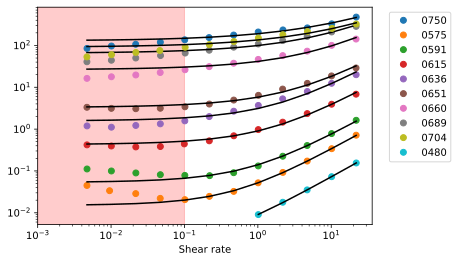

In [36]:
for label,fit_res in fit_res_dict.items():
  plt.plot(fit_res.userkws['x'],fit_res.data,'o', label=label)
  plt.plot(fit_res.userkws['x'],fit_res.eval(), color='black')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best', bbox_to_anchor=(1.25, 1))
plt.xlabel(xlabel)
plt.axvspan(0.001,min_shear_rate, color='red', alpha=0.2)
plt.xlim(0.001)

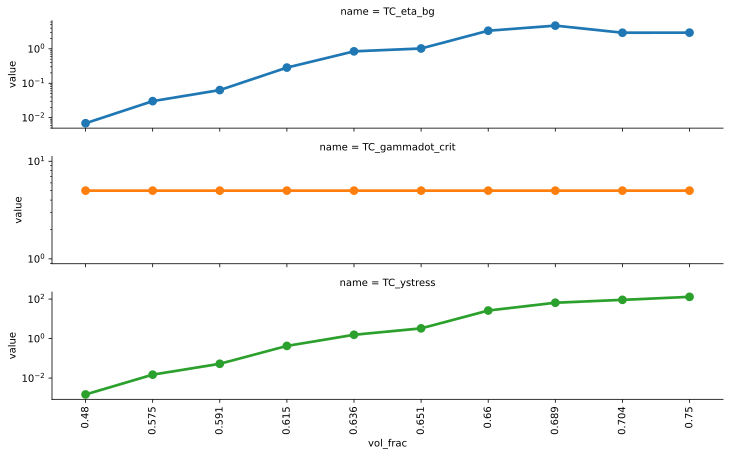

In [37]:
g = sns.catplot(x="vol_frac", y="value",
                hue="name", row="name",
                data=table_result, kind="point",
                dodge=False,
                sharey=False,
                height=2, aspect=5).set_xticklabels(rotation=90).set(yscale="log")

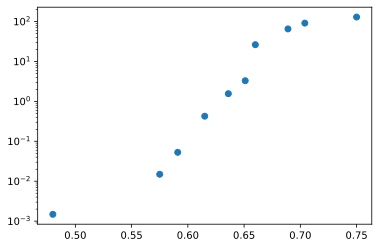

In [64]:
simple_table=table_result.pivot(index='vol_frac', columns='name', values='value')
plt.plot(list(simple_table.index),simple_table['TC_ystress'],'o')
plt.yscale('log')